## GitHub API Calling

In [49]:
import requests
import json

In [48]:
response = requests.get("https://api.github.com/repositories",
                        headers = {'Accept': 'application/vnd.github.v3+json'})

print(response.status_code)
print(response.encoding)
print(response.headers['content-type'])
print(response.headers['server'])

200
utf-8
application/json; charset=utf-8
GitHub.com


In [50]:
print(json.dumps(response.json()[0], indent = 2)[:200])

{
  "id": 1,
  "node_id": "MDEwOlJlcG9zaXRvcnkx",
  "name": "grit",
  "full_name": "mojombo/grit",
  "private": false,
  "owner": {
    "login": "mojombo",
    "id": 1,
    "node_id": "MDQ6VXNlcjE=",



In [11]:
response = requests.get('https://api.github.com/search/repositories')
print (response.status_code)

422


In [12]:
response = requests.get('https://api.github.com/search/repositories',
    params={'q': 'data_science+language:python'},
    headers={'Accept': 'application/vnd.github.v3.text-match+json'})
print(response.status_code)

200


In [19]:
for item in response.json()['items'][:5]:
    print('**' + item['name'] + '**' + ': repository ' +
            item['text_matches'][0]['property'] + ' - \"*' +
            item['text_matches'][0]['fragment'] + '*\" matched with ' + '**' +
            item['text_matches'][0]['matches'][0]['text'] + '**')
    print()

**data-science-from-scratch**: repository description - "*code for Data Science From Scratch book*" matched with **Data Science**

**data-science-blogs**: repository description - "*A curated list of data science blogs*" matched with **data science**

**galaxy**: repository description - "*Data intensive science for everyone.*" matched with **Data**

**data-scientist-roadmap**: repository description - "*Toturials coming with the "data science roadmap" picture.*" matched with **data science**

**DataCamp**: repository description - "*DataCamp data-science courses*" matched with **data**



In [42]:
response = requests.get(
    'https://api.github.com/repos/pytorch/pytorch/issues/comments'
)

In [43]:
print("Response Code", response.status_code)
print('Number of comments', len(response.json()))

Response Code 200
Number of comments 30


In [32]:
response.links

{'next': {'url': 'https://api.github.com/repositories/65600975/issues/comments?page=2',
  'rel': 'next'},
 'last': {'url': 'https://api.github.com/repositories/65600975/issues/comments?page=1334',
  'rel': 'last'}}

In [49]:
def get_all_pages(url, params=None, headers=None):
    output_json = []
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
        output_json = response.json()
        if 'next' in response.links:
            next_url = response.links['next']['url']
            if next_url is not None:
                output_json += get_all_pages(next_url, params, headers)
    return output_json

In [50]:
out = get_all_pages(
    "https://api.github.com/repos/pytorch/pytorch/issues/comments",
    params={
        'since': '2020-07-01T10:00:01Z',
        'sorted': 'created',
        'direction': 'desc'
    },
    headers={'Accept': 'application/vnd.github.v3+json'})

In [46]:
import pandas as pd

In [47]:
df = pd.DataFrame(out)

print (df['body'].count())
df[['id','created_at','body']].sample(1)

KeyError: 'body'

In [52]:
response = requests.head(
    'https://api.github.com/repos/pytorch/pytorch/issues/comments')
print('X-Ratelimit-Limit', response.headers['X-Ratelimit-Limit'])
print('X-Ratelimit-Remaining', response.headers['X-Ratelimit-Remaining'])

# Converting UTC time to human-readable format
import datetime
print(
    'Rate Limits reset at',
    datetime.datetime.fromtimestamp(int(
        response.headers['X-RateLimit-Reset'])).strftime('%c'))

X-Ratelimit-Limit 60
X-Ratelimit-Remaining 56
Rate Limits reset at Thu Dec 16 19:15:20 2021


In [53]:
from datetime import datetime
import time

def handle_rate_limits(response):
    now = datetime.now()
    reset_time = datetime.fromtimestamp(
        int(response.headers['X-RateLimit-Reset']))
    remaining_requests = response.headers['X-Ratelimit-Remaining']
    remaining_time = (reset_time - now).total_seconds()
    intervals = remaining_time / (1.0 + int(remaining_requests))
    print('Sleeping for', intervals)
    time.sleep(intervals)
    return True

In [54]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

retry_strategy = Retry(
    total=5,
    status_forcelist=[500, 503, 504],
    backoff_factor=1
)

retry_adapter = HTTPAdapter(max_retries=retry_strategy)

http = requests.Session()
http.mount("https://", retry_adapter)
http.mount("http://", retry_adapter)

response = http.get('https://api.github.com/search/repositories',
                   params={'q': 'data_science+language:python'})

for item in response.json()['items'][:5]:
    print (item['name'])

data-science-from-scratch
data-science-blogs
galaxy
data-scientist-roadmap
DataCamp


In [55]:
# putting all together

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

retry_strategy = Retry(
    total=5,
    status_forcelist=[500, 503, 504],
    backoff_factor=1
)

retry_adapter = HTTPAdapter(max_retries=retry_strategy)

http = requests.Session()
http.mount("https://", retry_adapter)
http.mount("http://", retry_adapter)

def get_all_pages(url, param=None, header=None):
    output_json = []
    response = http.get(url, params=param, headers=header)
    if response.status_code == 200:
        output_json = response.json()
        if 'next' in response.links:
            next_url = response.links['next']['url']
            if (next_url is not None) and (handle_rate_limits(response)):
                output_json += get_all_pages(next_url, param, header)
    return output_json

## Twitter API Calling

In [1]:
import tweepy
import pandas as pd
import numpy as np

In [2]:
app_api_key = '='
app_api_secret_key = '0'

In [3]:
auth = tweepy.AppAuthHandler(app_api_key, app_api_secret_key)

In [59]:
api = tweepy.API(auth)

In [66]:
print("API HOST", api.host)

API HOST api.twitter.com


In [67]:
search_term = 'cryptocurrency'

In [72]:
tweets = tweepy.Cursor(
    api.search_tweets,
    q = search_term,
    lang = 'en').items(200)

In [74]:
retrieved_tweets = [tweet._json for tweet in tweets]

In [76]:
df = pd.json_normalize(retrieved_tweets)

In [82]:
df[['text']].sample(4)

,text
166,RT @beeforenews: Breaking News Rating: 7/10\nC...
40,This is going big🔥💪🤑🤑\n\n#️⃣ $CINU #CheemsInu...
151,This is going big🔥💪🤑🤑\n\n#️⃣ $CINU #CheemsInu...
195,RT @Forbes: This year we watched society adapt...


### Extracting Data from the Search API

In [4]:
api = tweepy.API(
        auth,
        wait_on_rate_limit=True,
        retry_count=5,
        retry_delay=10
)

In [5]:
search_term = 'cryptocurrency OR crypto -filter:retweets'

In [6]:
tweets = tweepy.Cursor(
    api.search_tweets,
    q = search_term,
    lang = 'en',
    tweet_mode = 'extended',
    count = 30
).items(12000)

In [7]:
retrieved_tweets = list(tweet._json for tweet in tweets)

Rate limit reached. Sleeping for: 112


KeyboardInterrupt: 

In [128]:
df = pd.json_normalize(retrieved_tweets)
print('Number of retrieved tweets ', len(df))
df[['created_at','full_text','entities.hashtags']].sample(2)

Number of retrieved tweets  12000


,created_at,full_text,entities.hashtags
11617,Thu Dec 16 13:28:30 +0000 2021,@Crypto_Gina @galaxy_eggs Agree,[]
3707,Thu Dec 16 14:10:38 +0000 2021,@VersalNFT hellooooooo\n@nazar_crypto\n\n@quoc...,[]


In [106]:
def extract_entites(entity_list):
    entities = set()
    if len(entity_list) != 0:
        for item in entity_list:
            for key, value in item.items():
                if key == 'text':
                    entities.add(value.lower())
    return list(entities)

In [107]:
df['Entities'] = df['entities.hashtags'].apply(extract_entites)

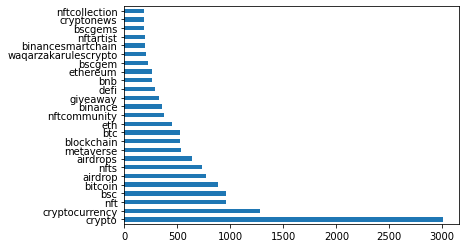

In [113]:
pd.Series(np.concatenate(df['Entities'])).value_counts()[:25].plot(kind='barh');

### Extracting Data from a User’s Timeline

In [8]:
api = tweepy.API(
        auth,
        wait_on_rate_limit=True
)

In [11]:
tweets = tweepy.Cursor(api.user_timeline,
                       screen_name='MercedesAMGF1',
                       tweet_mode='extended',
                       count=100).items(5000)

In [12]:
retrieved_tweets = [tweet._json for tweet in tweets]

In [19]:
df = pd.json_normalize(retrieved_tweets)
print("Number of tweet is: ", len(df))

Number of tweet is:  3250


In [16]:
def get_user_timeline(screen_name):
    api = tweepy.API(
        auth,
        wait_on_rate_limit=True
    )
    
    tweets = tweepy.Cursor(
        api.user_timeline,
        screen_name = screen_name,
        tweet_mode = "extended",
        count = 200
    ).items()
    
    retrieved_tweets = [tweet._json for tweet in tweets]
    
    df = pd.json_normalize(retrieved_tweets)
    df = df[~df['retweeted_status.id'].isna()]
    return df

In [17]:
df_mercedes = get_user_timeline('MercedesAMGF1')
print ('Number of Tweets from Mercedes', len(df_mercedes))
df_ferrari = get_user_timeline('ScuderiaFerrari')
print ('Number of Tweets from Ferrari', len(df_ferrari))

Number of Tweets from Mercedes 250
Number of Tweets from Ferrari 100


In [43]:
from exp import *

In [44]:
def wordcloud_blueprint(df, colName, max_words, num_stopwords):
    # Step 1: Convert input text column into tokens
    df['tokens'] = df[colName].map(prepare)
    
    # Step 2: Determine the frequency of each of the tokens
    freq_df = count_words(df)
    
    # Step 3: Generate the wordcloud using the frequencies controlling for stopwords
    wordcloud(freq_df['freq'], max_words, stopwords=freq_df.head(num_stopwords).index)
    return freq_df

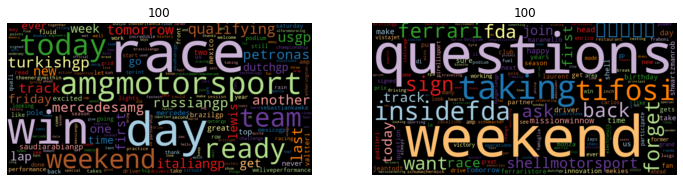

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  ###
df1 = wordcloud_blueprint(df_mercedes, 'full_text',
          max_words=100,
          num_stopwords=5)

plt.subplot(1, 2, 2)  ###
df2 = wordcloud_blueprint(df_ferrari, 'full_text',
          max_words=100,
          num_stopwords=5)